In [39]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
import pandas as pd

In [40]:
# 创建SparkSession
spark = SparkSession.builder.appName('Demand Prediction').getOrCreate()

from pyspark.sql.functions import col

In [41]:
# 导入数据
# data = spark.read.format("csv").option("header", "true").load("data/data_sample.csv")
data = spark.read.format("csv").option("header", "true").load("data/daily_demand_totals.csv")

In [42]:
# Convert the 'demand' column to a numeric type
data = data.withColumn("demand", col("demand").cast("double"))
# 数据清洗和准备
data = data.dropna()
data = data.withColumn("timestamp", to_timestamp(col("timestamp"), "yyyy-MM-dd HH:mm:ss"))
data = data.withColumn("year", year(col("timestamp")))
data = data.withColumn("month", month(col("timestamp")))
data = data.withColumn("day", dayofmonth(col("timestamp")))

In [43]:
# 特征工程
assembler = VectorAssembler(inputCols=["year", "month", "day"], outputCol="features")
data = assembler.transform(data)


In [44]:

# 划分训练和测试数据集
(train_data, test_data) = data.randomSplit([0.7, 0.3], seed=100)

# 数据探索

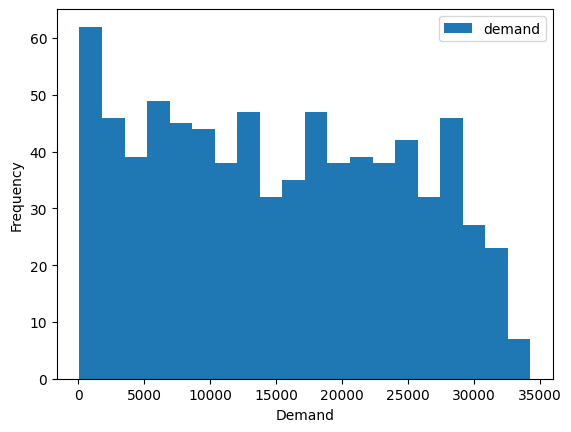

In [45]:
# 绘制demand的直方图
demand = pd.DataFrame(train_data.select('demand').rdd.map(lambda x: x[0]).collect(), columns=['demand'])
demand.plot(kind='hist', bins=20)
plt.xlabel('Demand')
plt.show()

/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


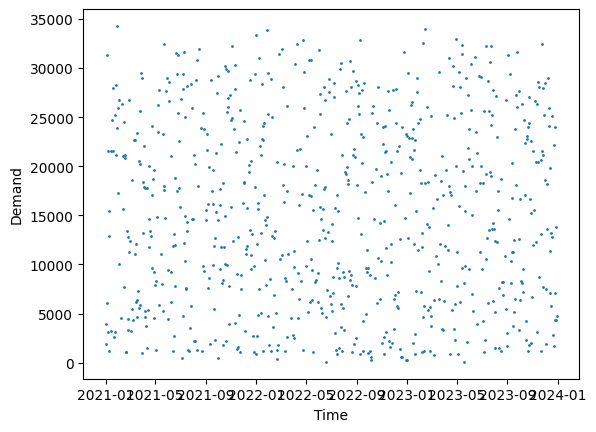

In [46]:
# 绘制demand和时间的散点图
data = train_data.select('timestamp', 'demand').toPandas()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='demand', kind='scatter', s=1)
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()

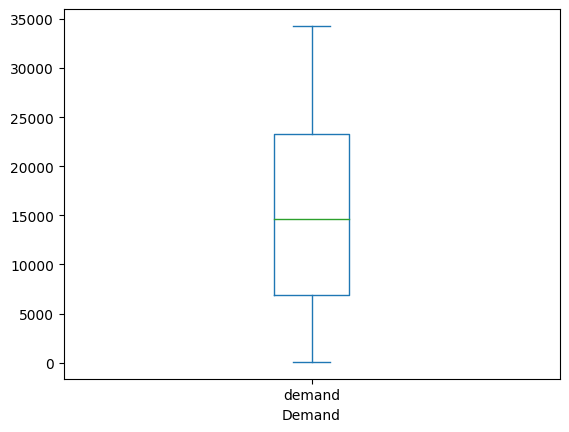

In [47]:
# 用箱线图来检测异常值和数据分布的形状
demand = pd.DataFrame(train_data.select('demand').rdd.map(lambda x: x[0]).collect(), columns=['demand'])
demand.plot(kind='box')
plt.xlabel('Demand')
plt.show()

In [48]:
# 定义线性回归模型
lr = LinearRegression(featuresCol="features", labelCol="demand")

# 训练模型
lr_model = lr.fit(train_data)

# 预测未来需求
predictions = lr_model.transform(test_data)

# 展示预测结果
predictions.select("year", "month", "day", "demand", "prediction").show()



23/03/03 02:30:58 WARN Instrumentation: [dd0edc1c] regParam is zero, which might cause numerical instability and overfitting.
+----+-----+---+-------+------------------+
|year|month|day| demand|        prediction|
+----+-----+---+-------+------------------+
|2021|    1|  4|16293.0|14692.672401553486|
|2021|    1| 11| 8284.0|14874.928462114622|
|2021|    1| 12|21330.0|14900.965042194788|
|2021|    1| 15| 9036.0|14979.074782435258|
|2021|    1| 16|18459.0|15005.111362515425|
|2021|    1| 20|22623.0| 15109.25768283609|
|2021|    1| 21|22252.0|15135.294262916257|
|2021|    1| 26|26410.0| 15265.47716331706|
|2021|    1| 30| 5076.0|15369.623483637726|
|2021|    2|  4|19558.0|  14702.9867044618|
|2021|    2|  5|27044.0|14729.023284541938|
|2021|    2|  7|17962.0| 14781.09644470227|
|2021|    2|  8|  207.0|14807.133024782437|
|2021|    2| 10|12406.0| 14859.20618494277|
|2021|    2| 11|16668.0|14885.242765022937|
|2021|    2| 18|25414.0|15067.498825584073|
|2021|    2| 22|23132.0|15171.64514590

In [49]:
# 创建随机森林回归模型
rf = RandomForestRegressor(featuresCol="features", labelCol="demand", numTrees=10)

# 训练模型
rf_model = rf.fit(train_data)

# 预测未来需求
predictions = rf_model.transform(test_data)

# 计算模型的评估指标（均方误差）
evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)

# 展示预测结果
predictions.select("year", "month", "day", "demand", "prediction").show()

# 输出均方误差
print("Mean Squared Error (MSE) on test data = %g" % mse)


+----+-----+---+-------+------------------+
|year|month|day| demand|        prediction|
+----+-----+---+-------+------------------+
|2021|    1|  4|16293.0|15000.917880856321|
|2021|    1| 11| 8284.0| 16831.98688165757|
|2021|    1| 12|21330.0| 16831.98688165757|
|2021|    1| 15| 9036.0| 16831.98688165757|
|2021|    1| 16|18459.0| 16831.98688165757|
|2021|    1| 20|22623.0| 16831.98688165757|
|2021|    1| 21|22252.0|15788.188548324233|
|2021|    1| 26|26410.0| 16235.99939738084|
|2021|    1| 30| 5076.0|17252.935047022063|
|2021|    2|  4|19558.0| 14112.40069187708|
|2021|    2|  5|27044.0| 14112.40069187708|
|2021|    2|  7|17962.0|15459.291180324444|
|2021|    2|  8|  207.0|15827.256180324443|
|2021|    2| 10|12406.0| 16410.81174968262|
|2021|    2| 11|16668.0|15279.740317310449|
|2021|    2| 18|25414.0|14835.723707174775|
|2021|    2| 22|23132.0|13337.032635746204|
|2021|    2| 28|21897.0|16549.792035387432|
|2021|    3|  1|25650.0|14483.107857555602|
|2021|    3|  4| 1179.0|14202.71

In [50]:
# 创建梯度提升树回归模型
gbt = GBTRegressor(featuresCol="features", labelCol="demand", maxIter=10)

# 训练模型
gbt_model = gbt.fit(train_data)

# 预测未来需求
predictions = gbt_model.transform(test_data)

# 计算模型的评估指标（均方误差）
evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)

# 展示预测结果
predictions.select("year", "month", "day", "demand", "prediction").show()

# 输出均方误差
print(" 3 Mean Squared Error (MSE) on test data = %g" % mse)

+----+-----+---+-------+------------------+
|year|month|day| demand|        prediction|
+----+-----+---+-------+------------------+
|2021|    1|  4|16293.0|14073.682797405341|
|2021|    1| 11| 8284.0|17208.371356640593|
|2021|    1| 12|21330.0| 15540.54437950455|
|2021|    1| 15| 9036.0|16446.231548507607|
|2021|    1| 16|18459.0| 16143.35269522089|
|2021|    1| 20|22623.0| 9829.261509339303|
|2021|    1| 21|22252.0| 9829.261509339303|
|2021|    1| 26|26410.0|30245.008389535047|
|2021|    1| 30| 5076.0|26380.369684877016|
|2021|    2|  4|19558.0|13552.769579195554|
|2021|    2|  5|27044.0|10927.825867684001|
|2021|    2|  7|17962.0|13489.887732934116|
|2021|    2|  8|  207.0|14319.921279986811|
|2021|    2| 10|12406.0|15197.321616010444|
|2021|    2| 11|16668.0|   10046.253471933|
|2021|    2| 18|25414.0| 13250.07503811476|
|2021|    2| 22|23132.0|11323.256563922363|
|2021|    2| 28|21897.0|21965.539177394025|
|2021|    3|  1|25650.0|12227.781503986122|
|2021|    3|  4| 1179.0|13124.76

In [51]:
print('#'*20)
import matplotlib.pyplot as plt

# 使用三种不同的模型进行预测
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)

# 使用均方误差评估每个模型的预测效果
lr_evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
lr_mse = lr_evaluator.evaluate(lr_predictions)
rf_evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
rf_mse = rf_evaluator.evaluate(rf_predictions)
gbt_evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
gbt_mse = gbt_evaluator.evaluate(gbt_predictions)



####################


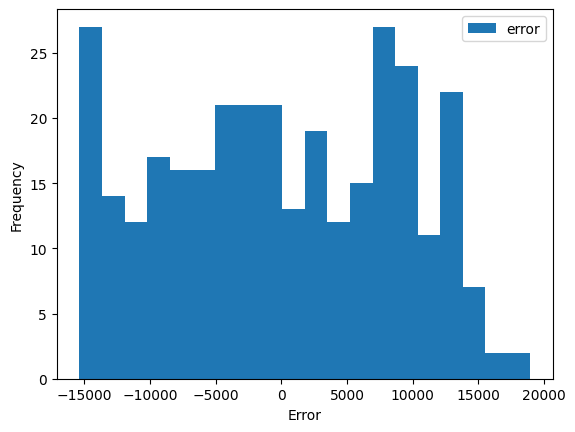

In [52]:
# 选取 lr_model作为例子 预测误差分布图来观察模型的预测误差是否符合正态分布
# 计算预测误差
lr_predictions = lr_model.transform(test_data)
lr_errors = lr_predictions.select("demand", "prediction").rdd.map(lambda x: x[0] - x[1]).collect()

# 绘制预测误差分布图
pd.DataFrame(lr_errors, columns=['error']).plot(kind='hist', bins=20)
plt.xlabel('Error')
plt.show()

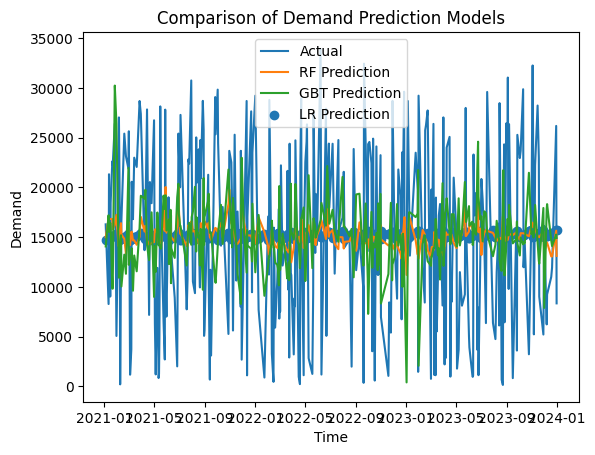

Linear Regression Mean Squared Error (MSE) on test data = 7.87581e+07
Random Forest Mean Squared Error (MSE) on test data = 7.98739e+07
Gradient Boosting Tree Mean Squared Error (MSE) on test data = 9.56987e+07


In [53]:
# 创建一个时间序列的数组
time_series = test_data.select("timestamp").rdd.flatMap(lambda x: x).collect()

# Create a matplotlib chart and plot the actual demand and predictions from each model
fig, ax = plt.subplots()
ax.plot(time_series, test_data.select("demand").collect(), label="Actual")
ax.plot(time_series, rf_predictions.select("prediction").collect(), label="RF Prediction")
ax.plot(time_series, gbt_predictions.select("prediction").collect(), label="GBT Prediction")
ax.scatter(time_series, lr_predictions.select("prediction").collect(), label="LR Prediction")
ax.set_xlabel("Time")
ax.set_ylabel("Demand")
ax.set_title("Comparison of Demand Prediction Models")
ax.legend()

# Show the chart
plt.show()


# 输出评估结果
print("Linear Regression Mean Squared Error (MSE) on test data = %g" % lr_mse)
print("Random Forest Mean Squared Error (MSE) on test data = %g" % rf_mse)
print("Gradient Boosting Tree Mean Squared Error (MSE) on test data = %g" % gbt_mse)


In [54]:
print('在预测结果可视化图表中，随机森林(Random Forest)模型和梯度提升树(Gradient Boosting Tree)模型的预测结果比线性回归(Linear Regression)模型的预测结果更接近实际需求值')

在预测结果可视化图表中，随机森林(Random Forest)模型和梯度提升树(Gradient Boosting Tree)模型的预测结果比线性回归(Linear Regression)模型的预测结果更接近实际需求值
